In [14]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [15]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)


optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/btest031.pickle
optimization/btest032.pickle
optimization/btest033.pickle
optimization/b

In [16]:
opt_summary = {k:[] for k in cfgs[0].keys()}
for k in opt_summary.keys():
    for cfg in cfgs:
        v = cfg[k]
        if type(v) is EasyDict and "func" in v.keys():
            opt_summary[k].append(str(v.func.name))
        else:
            opt_summary[k].append(v)
            
opt_summary["btest"], opt_summary["ndeals"] = [], []
for btest in btests:
    opt_summary["btest"].append(btest.profits.sum())
    opt_summary["ndeals"].append(len(btest.profits))
    
opt_summary = pd.DataFrame(opt_summary)
opt_summary.sort_values(by=["btest"], ascending=False, inplace=True)
opt_summary = opt_summary[opt_summary.ticker != "NVTK"]
opt_summary.head(10)

,date_start,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
17,2008-01-01,0.02,1,trend:2,stops_fix:100-4,9999,30,0,None,H1,ETHUSD,bitfinex,False,418.294806,568
0,2008-01-01,0.01,1,trend:2,stops_fix:100-1,9999,30,0,None,H1,BTCUSD,bitfinex,False,412.598755,682
16,2008-01-01,0.02,1,trend:2,stops_fix:100-4,9999,30,0,None,H1,BTCUSD,bitfinex,False,402.629770,479
2,2008-01-01,0.01,1,trend:2,stops_fix:100-2,9999,30,0,None,H1,BTCUSD,bitfinex,False,375.417812,497
15,2008-01-01,0.02,1,trend:2,stops_fix:100-2,9999,30,0,None,H1,ETHUSD,bitfinex,False,372.688981,740
4,2008-01-01,0.01,1,trend:2,stops_fix:100-4,9999,30,0,None,H1,BTCUSD,bitfinex,False,353.264066,355
6,2008-01-01,0.01,1,trend:3,stops_fix:100-1,9999,30,0,None,H1,BTCUSD,bitfinex,False,345.500183,417
1,2008-01-01,0.01,1,trend:2,stops_fix:100-1,9999,30,0,None,H1,ETHUSD,bitfinex,False,345.126766,797
5,2008-01-01,0.01,1,trend:2,stops_fix:100-4,9999,30,0,None,H1,ETHUSD,bitfinex,False,338.708748,433
13,2008-01-01,0.02,1,trend:2,stops_fix:100-1,9999,30,0,None,H1,ETHUSD,bitfinex,False,327.858418,947


In [17]:
opt_res = {"param_set":[], "ticker":[], "btest":[], "ndeals":[], "test_ids":[]}
for i in range(opt_summary.shape[0]):
    exphash, test_ids = "", ""
    for col in opt_summary.columns:
        if col not in ["ticker", "btest", "ndeals"]:
            exphash += str(opt_summary[col].iloc[i]) + " "
    opt_res["test_ids"].append(f".{opt_summary.index[i]}")
    opt_res["param_set"].append(exphash)
    opt_res["ticker"].append(f".{opt_summary.ticker.iloc[i]}")
    opt_res["ndeals"].append(opt_summary.ndeals.iloc[i])
    opt_res["btest"].append(opt_summary.btest.iloc[i])

opt_res = pd.DataFrame(opt_res)
opt_res = opt_res.groupby(by="param_set").sum()
opt_res.sort_values(by=["btest"], ascending=False, inplace=True)
opt_res.head(20)

,ticker,btest,ndeals,test_ids
param_set,,,,
2008-01-01 0.02 1 trend:2 stops_fix:100-4 9999 30 0 None H1 bitfinex False,.ETHUSD.BTCUSD,820.924576,1047,.17.16
2008-01-01 0.01 1 trend:2 stops_fix:100-1 9999 30 0 None H1 bitfinex False,.BTCUSD.ETHUSD,757.725522,1479,.0.1
2008-01-01 0.01 1 trend:2 stops_fix:100-2 9999 30 0 None H1 bitfinex False,.BTCUSD.ETHUSD,702.193245,1104,.2.3
2008-01-01 0.02 1 trend:2 stops_fix:100-2 9999 30 0 None H1 bitfinex False,.ETHUSD.BTCUSD,700.173146,1389,.15.14
2008-01-01 0.01 1 trend:2 stops_fix:100-4 9999 30 0 None H1 bitfinex False,.BTCUSD.ETHUSD,691.972814,788,.4.5
2008-01-01 0.02 1 trend:2 stops_fix:100-1 9999 30 0 None H1 bitfinex False,.ETHUSD.BTCUSD,608.968047,1806,.13.12
2008-01-01 0.04 1 trend:2 stops_fix:100-2 9999 30 0 None H1 bitfinex False,.ETHUSD.BTCUSD,438.110496,1746,.27.26
2008-01-01 0.04 1 trend:2 stops_fix:100-1 9999 30 0 None H1 bitfinex False,.BTCUSD.ETHUSD,436.688914,2115,.24.25
2008-01-01 0.02 1 trend:3 stops_fix:100-4 9999 30 0 None H1 bitfinex False,.BTCUSD.ETHUSD,412.934367,774,.22.23


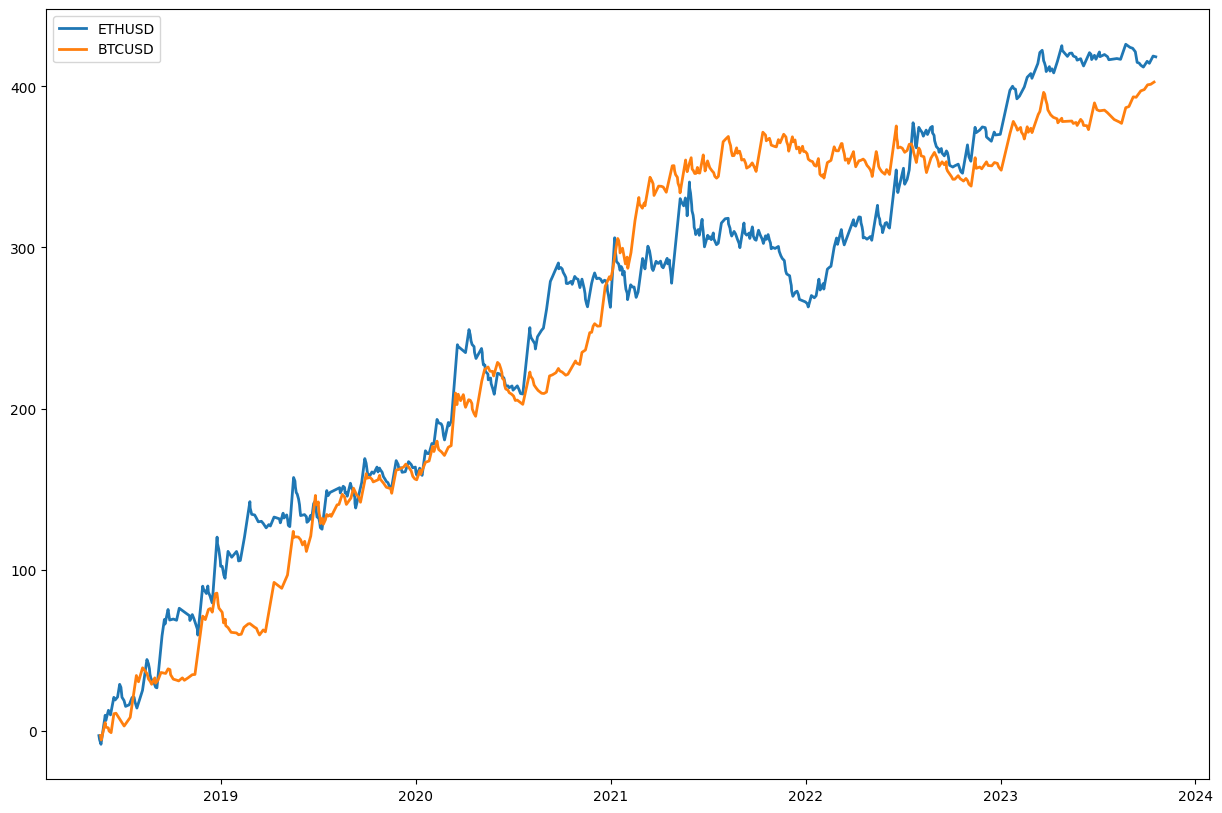

In [18]:
plt.figure(figsize=(15, 10))
opt_res_id = 0
legend = []
for test_id in map(int, opt_res.test_ids.iloc[opt_res_id].split(".")[1:]):
    plt.plot([pos.close_date for pos in btests[test_id].positions], 
             btests[test_id].profits.cumsum(), 
             linewidth=2)
    legend.append(cfgs[test_id].ticker)
plt.legend(legend)

In [13]:
opt_summary_loc = opt_summary[opt_summary.ticker == "BTCUSD"]
opt_summary_loc.head()

,date_start,trailing_stop_rate,trailing_stop_type,body_classifier,stops_processor,wait_entry_point,hist_buffer_size,tstart,tend,period,ticker,data_type,save_plots,btest,ndeals
0,2008-01-01,0.01,1,trend:3,stops_fix:100-1,9999,30,0,None,H1,BTCUSD,bitfinex,False,345.500183,417
10,2008-01-01,0.02,1,trend:3,stops_fix:100-4,9999,30,0,None,H1,BTCUSD,bitfinex,False,315.043544,350
4,2008-01-01,0.01,1,trend:3,stops_fix:100-4,9999,30,0,None,H1,BTCUSD,bitfinex,False,293.622715,273
2,2008-01-01,0.01,1,trend:3,stops_fix:100-2,9999,30,0,None,H1,BTCUSD,bitfinex,False,277.528359,343
6,2008-01-01,0.02,1,trend:3,stops_fix:100-1,9999,30,0,None,H1,BTCUSD,bitfinex,False,271.294825,485
